## This notebook generates Figure 3 of the paper "iCSD produces spurious results in dense electrode arrays"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from cinplaAnalysis.utils import *

%matplotlib ipympl

In [2]:
from cinplaAnalysis.icsd import StandardCSD, DeltaiCSD, StepiCSD

In [3]:
import matplotlib

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [4]:
matplotlib.rcParams['savefig.pad_inches'] = 0

In [5]:
def plotFig(ax,csd,breaks=None,absmax=None,timeLimited=False,plotCB=False,xlabels=False,title=None):

    if breaks is not None:
        for b in breaks:
            ax.plot([0,3000],[b,b],c='k')

    if absmax is None:
        absmax = np.max(np.abs(csd))/2
    
    im = ax.imshow(np.array(csd), origin='lower', vmin =-absmax,vmax=absmax, cmap='bwr_r')
    ax.axis(ax.axis('tight'))

    if plotCB:
        cb = plt.colorbar(im, ax=ax)
        cb.formatter.set_powerlimits((0,0))


    ax.set_yticklabels([])

    if xlabels:
        ax.set_xticks([2000,2050],labels=['0','50'])
        ax.set_xlabel('Time (ms)')
    else:
        ax.set_xticklabels([])

    if timeLimited:
        ax.set_xlim([50,100])
    else:
        ax.set_xlim([2000,2050])

    if title:
        plt.title(title)

    plt.tight_layout()

In [6]:
# Loads results LFP and oCSD averaged over trials in the simualtion campaign with electrodes with 40 um spacing

lowRes = np.load('../radii/total.npy')




In [7]:
idx_200 = np.arange(101) # Indices in the output file for objective disk CSD with 40 um spacing
idx_100 = np.arange(101,202) # Indices in the output file for objective disk CSD with 80 um spacing
idx_50 = np.arange(202,303) # Indices in the output file for objective disk CSD with 160 um spacin
idx_20 = np.arange(303,404) # Indices in the output file for objective disk CSD with 160 um spacin
idx_10 = np.arange(404,505) # Indices in the output file for objective disk CSD with 160 um spacing

disk200 = lowRes[:,idx_200]
disk100 = lowRes[:,idx_100]
disk50 = lowRes[:,idx_50]
disk20 = lowRes[:,idx_20]
disk10 = lowRes[:,idx_10]


In [8]:
highRes = np.load('total.npy')

In [9]:
idx_5 = np.arange(101) # Indices in the output file for objective disk CSD with 40 um spacing
idx_2 = np.arange(101,202) # Indices in the output file for objective disk CSD with 80 um spacing
idx_1 = np.arange(202,303) # Indices in the output file for objective disk CSD with 160 um spacin
disk5 = highRes[:,idx_5]
disk2 = highRes[:,idx_2]
disk1 = highRes[:,idx_1]

In [10]:
depthHighRes = np.linspace(0,2000,51)


In [11]:
### This cell calculates the iCSD from the recorded LFP

highRes = np.load('../highRes/total.npy')
lfpIdx = np.arange(101) # Indices in the output file for LFP electrodes
totalLFPHighRes = highRes[:,lfpIdx]

diams = [500,200,100,50,20,10,5,2,1]

icsds = []

for diam in diams:

    diam *= 1e-6* pq.m                              # [m]
    sigma = 0.376 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
    sigma_top = 0.376 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]
    
    # Input dictionaries for each method
    
    
    step_input_high = {
        'lfp' : totalLFPHighRes.T * 1E-3 * pq.V,   # [mV] -> [V],
        'coord_electrode' : 20 * np.arange(0,101) * 1e-6 * pq.m,
        'sigma' : sigma,
        'h':20E-6 * pq.m ,
        'f_type' : 'gaussian',
        'f_order' : (3, 1),
    }
    
    icsd_high = StepiCSD(**step_input_high)
    icsds.append(icsd_high)

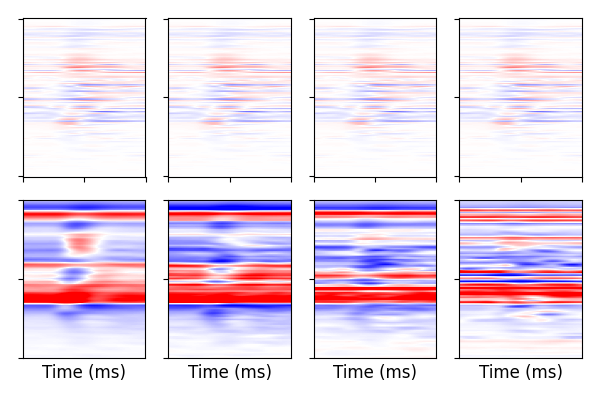

In [12]:
### This cell plots Figure 3 a

fig, axes = plt.subplots(2,4,figsize=(6,4))

for i in range(4):
    plotFig(axes[0][i],icsds[i].get_csd(),xlabels=False)

plotFig(axes[1][0],disk200.T,xlabels=True,timeLimited=True)

plotFig(axes[1][1],disk100.T,xlabels=True,timeLimited=True)

plotFig(axes[1][2],disk50.T,xlabels=True,timeLimited=True)

plotFig(axes[1][3],disk20.T,xlabels=True,timeLimited=True)

# plotFig(axes[1][4],disk10.T,xlabels=True,timeLimited=True)

# plotFig(axes[1][5],disk5.T,xlabels=True,timeLimited=True)

# plotFig(axes[1][6],disk2.T,xlabels=True,timeLimited=True)

# plotFig(axes[1][7],disk1.T,xlabels=True,timeLimited=True)



In [16]:
### This cell calcualtes the correlation between iCSD and objective disk CSD for each of the electrode densities

correlations_200 = []
correlations_100 = []
correlations_50 = []
correlations_20 = []
correlations_10 = []
correlations_5 = []
correlations_2 = []
correlations_1 = []

for i in np.arange(2000,2050):
    correlations_200.append(np.corrcoef(icsds[0].get_csd()[:,i],disk200.T[:,i-1950])[0,1])
    correlations_100.append(np.corrcoef(icsds[1].get_csd()[:,i],disk100.T[:,i-1950])[0,1])
    correlations_50.append(np.corrcoef(icsds[2].get_csd()[:,i],disk50.T[:,i-1950])[0,1])
    correlations_20.append(np.corrcoef(icsds[3].get_csd()[:,i],disk20.T[:,i-1950])[0,1])
    correlations_10.append(np.corrcoef(icsds[3].get_csd()[:,i],disk10.T[:,i-1950])[0,1])
    correlations_5.append(np.corrcoef(icsds[3].get_csd()[:,i],disk5.T[:,i-1950])[0,1])
    correlations_2.append(np.corrcoef(icsds[3].get_csd()[:,i],disk2.T[:,i-1950])[0,1])
    correlations_1.append(np.corrcoef(icsds[3].get_csd()[:,i],disk1.T[:,i-1950])[0,1])


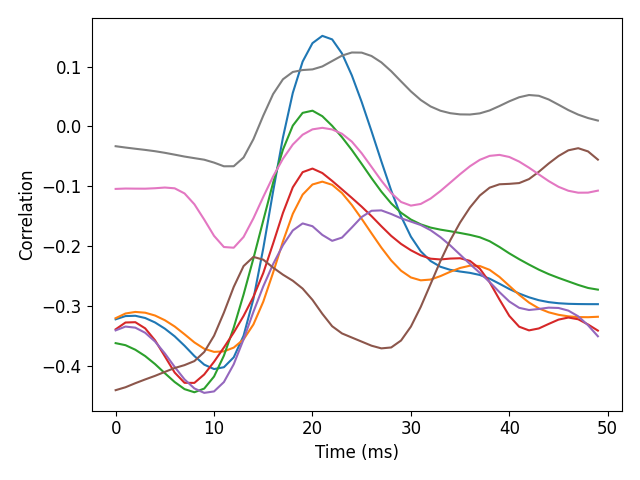

In [17]:
### This cell plots Figure 3 b

plt.figure()
plt.plot(correlations_200)
plt.plot(correlations_100)
plt.plot(correlations_50)
plt.plot(correlations_20)
plt.plot(correlations_10)
plt.plot(correlations_5)
plt.plot(correlations_2)
plt.plot(correlations_1)

plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.tight_layout()
# plt.savefig('figures/correlations.png',dpi=300)

In [18]:
noNeg = np.load('../secondDeriv/total.npy')

In [19]:
noNeg.shape

(101, 100)

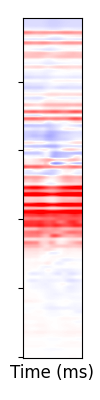

In [23]:
fig, axes = plt.subplots(1,1,figsize=(1,4))
plotFig(axes,noNeg.T[:-1],xlabels=True,timeLimited=True)

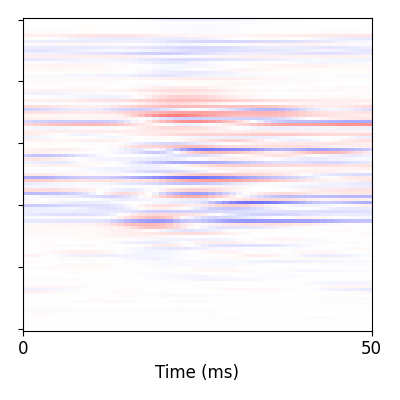

In [25]:
fig, axes = plt.subplots(1,1,figsize=(4,4))
plotFig(axes,icsds[0].get_csd(),xlabels=True)

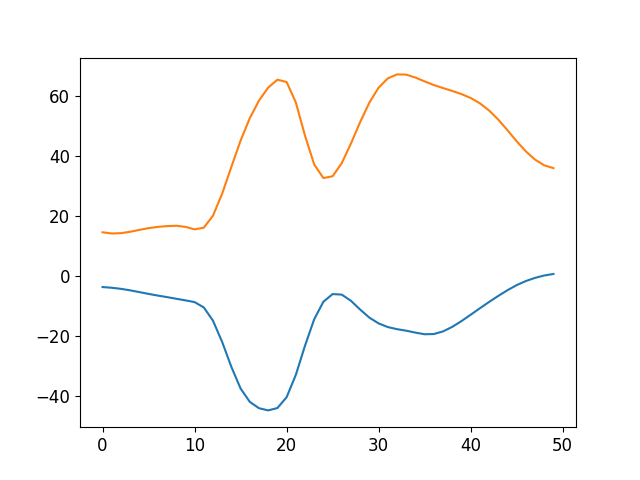

In [27]:
plt.figure()
plt.plot(icsd_high.get_csd()[34][2000:2050])
plt.plot(icsd_high.get_csd()[35][2000:2050])

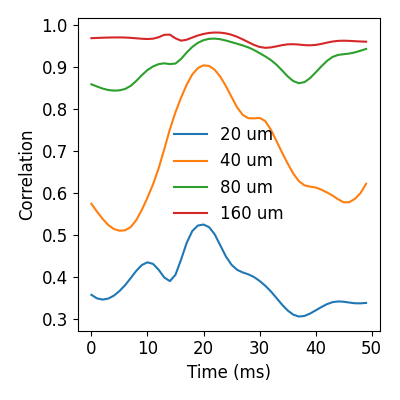

In [23]:
### This cell plots Figure 3 b again, but with the legend

plt.figure(figsize=(4,4))
plt.plot(correlations_high_stim,c='C0',linestyle=None)
plt.plot(correlations_low_stim,c='C1',linestyle=None)
plt.plot(correlations_low_half_stim,c='C2',linestyle=None)
plt.plot(correlations_low_quarter_stim,c='C3',linestyle=None)

plt.legend(['20 um', '40 um','80 um','160 um'],framealpha=0)
plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.tight_layout()
plt.savefig('figures/correlations_legend.png',dpi=300)